<a href="https://colab.research.google.com/github/Lyshen/PiggyToy/blob/main/Lesson03_CNN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lesson 3. Simple CNN excerise
## 1. Improve lesson 2's code
## 2. Save the usually-used code
## 3. Try to implement your simple CNN using the MNIST dataset
## 4. Compare the results between CNN and DNN
## 5. Maybe it is slow. Try to improve the speed of the SGD


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_features_and_labels(features, labels, size_of_class, markers, colors, title):
    plt.figure(figsize=(3,3))
    for i in range(size_of_class):
        x = features[np.where(labels[:, i] == 1), 0]
        y = features[np.where(labels[:, i] == 1), 1]
        plt.scatter(x, y, marker=markers[i], c=colors[i])
    plt.title(title)
    plt.show()


def split_train_and_test_data(feature_matrix, label_matrix, split_rate = 0.9):
    m = feature_matrix.shape[0]
    split_index = int(m * split_rate)

    indices = np.array(range(m))
    np.random.shuffle(indices)

    train_indices, test_indices = np.array(indices[0:split_index]), np.array(indices[split_index:])
    train_features, train_labels = feature_matrix[train_indices, :], label_matrix[train_indices, :]
    test_features, test_labels = feature_matrix[test_indices, :], label_matrix[test_indices, :]

    return train_features, train_labels, test_features, test_labels


def draw_neuron_boundary(neuron, features, labels, markers, colors, grid_step=0.5, size_of_class= 2):
    min_x, max_x = np.min(features[:, 0]), np.max(features[:, 0])
    min_y, max_y = np.min(features[:, 1]), np.max(features[:, 1])

    xx, yy = np.meshgrid(np.arange(min_x - 1, max_x + 1, grid_step), np.arange(min_y - 1, max_y + 1, grid_step))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    predict = neuron.predict(grid_points)
    argmax_index = np.argmax(predict, axis=1)

    positive_index = grid_points[np.where(argmax_index == 0), :]
    negative_index = grid_points[np.where(argmax_index == 1), :]

    plt.figure(figsize=(4, 4))
    for i in range(size_of_class):
        class_index = grid_points[np.where(argmax_index == i), :]
        plt.scatter(class_index[0, :, 0], class_index[0, :, 1], c=colors[i], alpha=0.1)

    for i in range(size_of_class):
        x = features[np.where(labels[:, i] == 1), 0]
        y = features[np.where(labels[:, i] == 1), 1]
        plt.scatter(x, y, marker=markers[i], c=colors[i])

    plt.show()

#Exercise 1. Do a warm up exercise with double moon dataset
## 1. Design a complex multiple classes classfication problem
## 2. Try to use lesson 2's code
## 3. Improve lesson 2's code


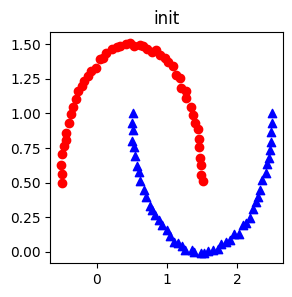

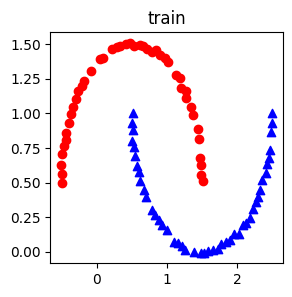

In [3]:
from sklearn.datasets import make_moons, make_circles

time_of_iter = 1
size_of_sample = 100
size_of_features = 2
size_of_class = 2 * time_of_iter

markers = ['o', '^', '*', '>']
colors = ['r', 'b', 'g', 'y']
noises = [0.01, 0.06]
random_indexs = [0.5, 1.7]

feature_list = []
labels = np.zeros((size_of_sample * time_of_iter, size_of_class))

for i in range(time_of_iter):
    moon_features, moon_labels = make_moons(n_samples=size_of_sample, noise=noises[i])
    random_matrix = np.ones(moon_features.shape) * random_indexs[i]
    moon_features = moon_features + random_matrix

    for j in range(2):
        index = i * 2 + j
        matrix_where = i * size_of_sample + np.array(np.where(moon_labels == j))
        labels[matrix_where, index] = 1
    feature_list.append(moon_features)

features = np.concatenate(feature_list, axis=0)
train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')
#plot_features_and_labels(test_features, test_labels, size_of_class, markers, colors, 'test')

In [4]:
# Re implement simple DNN
sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))

# array / vector  very carefully
softmax = lambda a: np.exp(a) / (np.sum(np.exp(a), axis=1)[:, np.newaxis])

class Linear:
    def __init__(self, in_size, out_size = 1):
        self.in_size = in_size + 1
        self.out_size = out_size
        self.X = None
        self.W = np.random.uniform(-1., 1., size=(self.in_size, self.out_size))
        self.dL_by_dW = None

    def forward(self, X):
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = self.X.dot(self.W)
        return Z

    def backward(self, dL_by_dZ):
        # Matrix Z = XW   X(m, n+1) W(n+1, out) Z(m, out)
        # dL/dZ = (m, out) dZ/dX = W.T  (out, n+1)  dZ/dW = X.T (n+1, m)
        # dL/dW = dZ/dW * dL/dZ  (n+1, out)
        # dL/dX = dL/dZ * dZ/dX  (m, n+1)

        # backward dL/dX and record dL/dW
        dZ_by_dW = self.X.T  #(n+1, m)
        dZ_by_dX = self.W.T  #(out, n+1)
        dL_by_dX = dL_by_dZ.dot(dZ_by_dX) #(m, n+1)
        self.dL_by_dW = dZ_by_dW.dot(dL_by_dZ) #(n+1, out)
        return dL_by_dX[:, :-1]

    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = X.dot(self.W)
        return Z

    def update_weights(self, learning_rate):
        self.W = self.W - self.dL_by_dW * learning_rate


class Sigmoid_Active_Function:
    def __init__(self):
        self.active_function = sigmoid
        self.H = None

    def forward(self, X):
        self.H = self.active_function(X)
        return self.H

    def backward(self, up_gradient):
        self.local_gradient = (1 - self.H) * self.H
        down_gradient = up_gradient * self.local_gradient
        return down_gradient

    def predict(self, X):
        H = self.active_function(X)
        return H

    def update_weights(self, learning_rate):
        return

class Cross_Entropy_Loss:
    def __init__(self):
        self.process_function = softmax

    def forward(self, Z, Y):
        self.Y_hat = self.process_function(Z)
        self.loss = -1. * np.sum(Y * np.log(self.Y_hat, where= self.Y_hat != 0)) #KL divergence
        return self.Y_hat, self.loss

    def backward(self, Y):
        # Math provement
        self.dL_by_dZ = self.Y_hat - Y
        return self.dL_by_dZ

In [5]:
class Operator_Packager:
    def __init__(self, operator_list):
        self.operator_list = operator_list

    def forward(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].forward(Z)
        return Z

    def backward(self, E):
        d = E
        size = len(self.operator_list)
        for i in range(size):
            index = size - 1 - i
            d = self.operator_list[index].backward(d)
        return d

    def predict(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].predict(Z)
        Y_hat = softmax(Z)
        return Y_hat

    def update_weights(self, learning_rate):
        size = len(self.operator_list)
        for i in range(size):
            self.operator_list[i].update_weights(learning_rate)


In [6]:
class SimpleDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 3),
            Sigmoid_Active_Function(),
            Linear(3, 3),
            Sigmoid_Active_Function(),
            Linear(3, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)


(90, 2)
(90, 2)


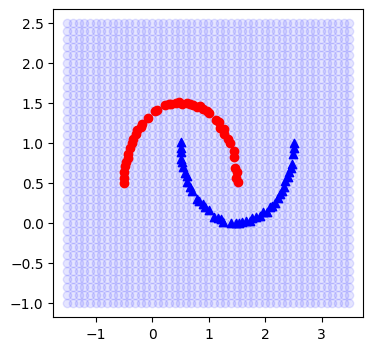

Epoch 1
-------------------------------
loss : 0.3441467942020984


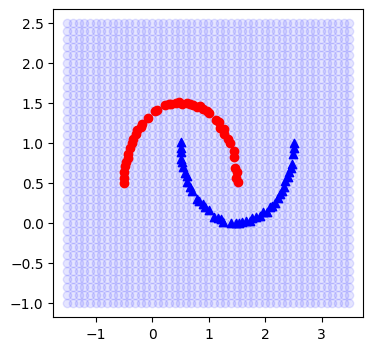

loss : 0.8895426258642191


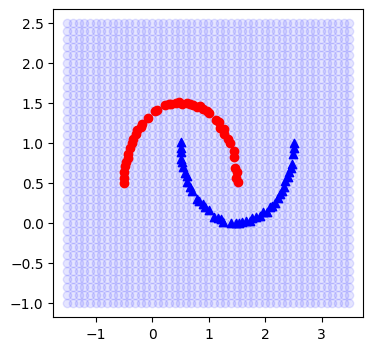

Epoch 21
-------------------------------
loss : 0.12125507343381557


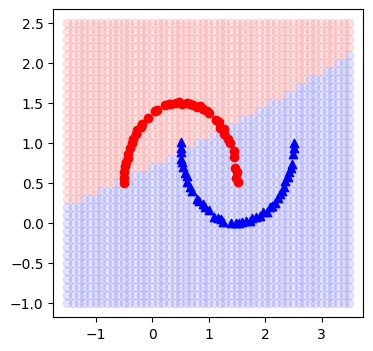

loss : 0.17930937675647823


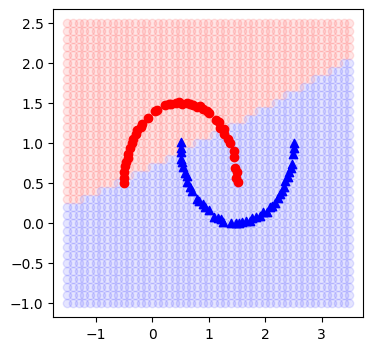

Epoch 41
-------------------------------
loss : 0.06407579493698644


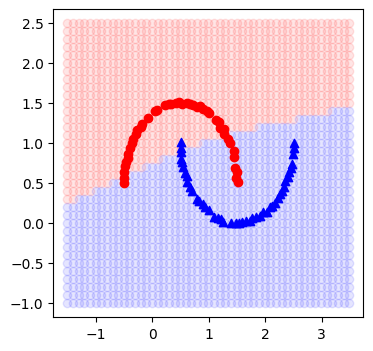

loss : 0.10707853351192201


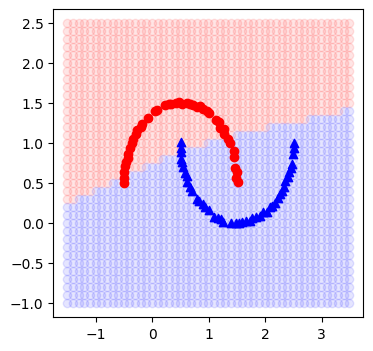

Epoch 61
-------------------------------
loss : 0.039270721431058954


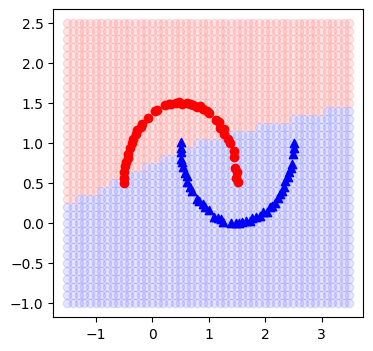

loss : 0.12398121113991852


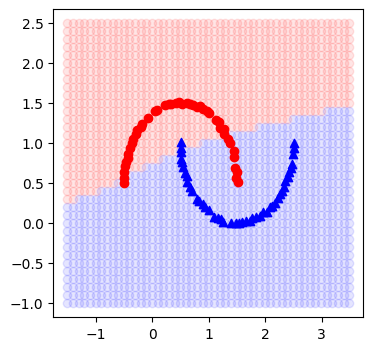

In [7]:
demo_neuron = SimpleDNN(2, 2)
loss = Cross_Entropy_Loss()

print(train_features.shape)
print(train_labels.shape)

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 80
m = train_labels.shape[0]
for t in range(epochs):
    if t % 20 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 20 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

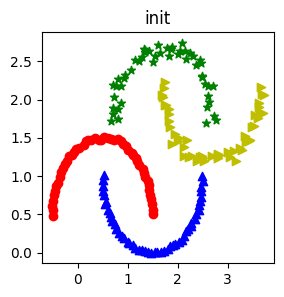

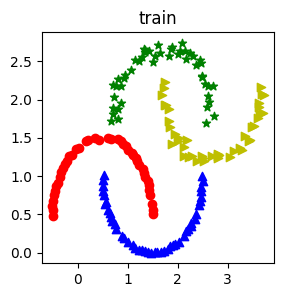

In [8]:
from sklearn.datasets import make_moons, make_circles

time_of_iter = 2
size_of_sample = 100
size_of_features = 2
size_of_class = 2 * time_of_iter

markers = ['o', '^', '*', '>']
colors = ['r', 'b', 'g', 'y']
noises = [0.01, 0.06]
random_indexs = [0.5, 1.7]

feature_list = []
labels = np.zeros((size_of_sample * time_of_iter, size_of_class))

for i in range(time_of_iter):
    moon_features, moon_labels = make_moons(n_samples=size_of_sample, noise=noises[i])
    random_matrix = np.ones(moon_features.shape) * random_indexs[i]
    moon_features = moon_features + random_matrix

    for j in range(2):
        index = i * 2 + j
        matrix_where = i * size_of_sample + np.array(np.where(moon_labels == j))
        labels[matrix_where, index] = 1
    feature_list.append(moon_features)

features = np.concatenate(feature_list, axis=0)
train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')

In [9]:
class SimpleDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 3),
            Sigmoid_Active_Function(),
            Linear(3, 3),
            Sigmoid_Active_Function(),
            Linear(3, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)


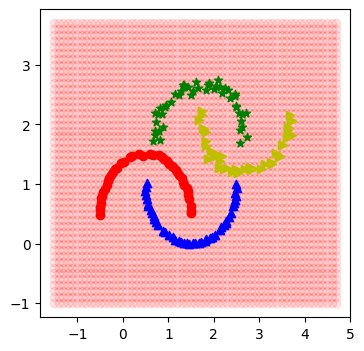

Epoch 1
-------------------------------
loss : 2.331069664713523


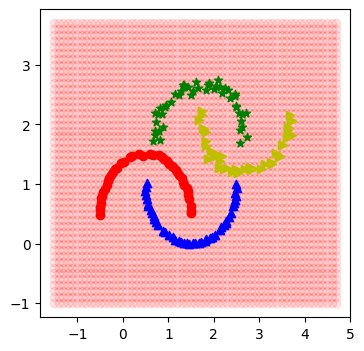

loss : 1.631923812041711


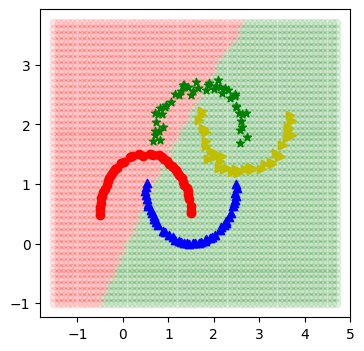

Epoch 11
-------------------------------
loss : 0.1892434210320631


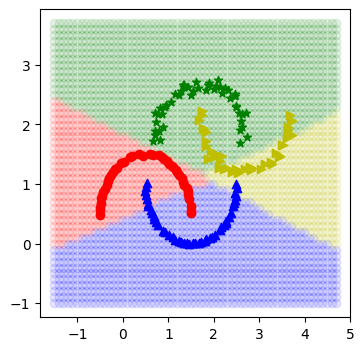

loss : 0.26183387336146297


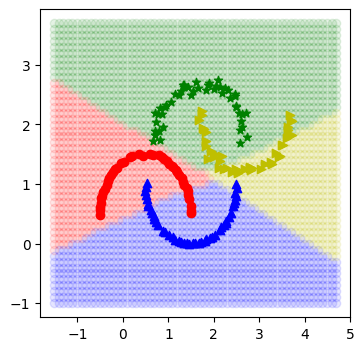

Epoch 21
-------------------------------
loss : 0.18006432043935447


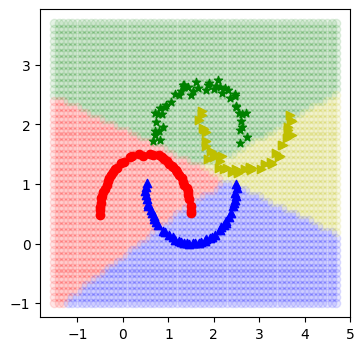

loss : 0.39164177098649916


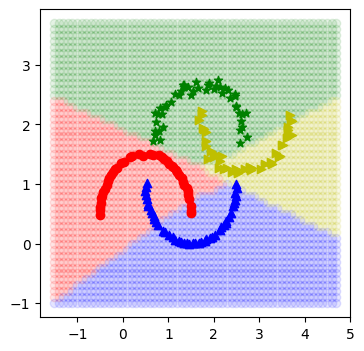

Epoch 31
-------------------------------
loss : 0.1671445395283689


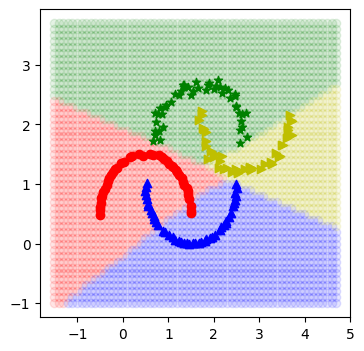

loss : 0.3426874054204538


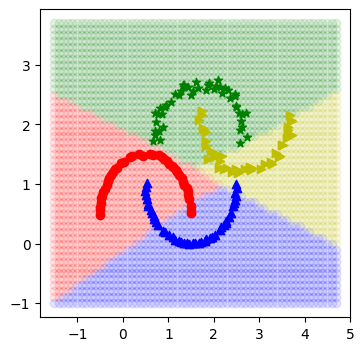

Epoch 41
-------------------------------
loss : 0.15482727879944114


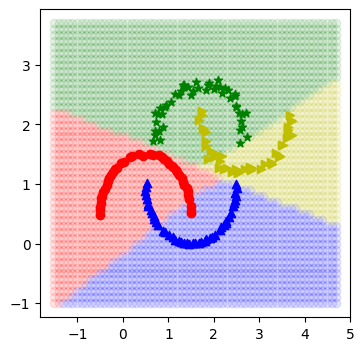

loss : 0.5145316457041511


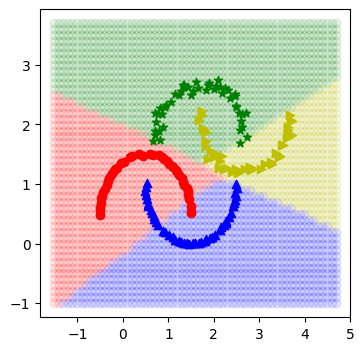

Epoch 51
-------------------------------
loss : 0.15759412639348708


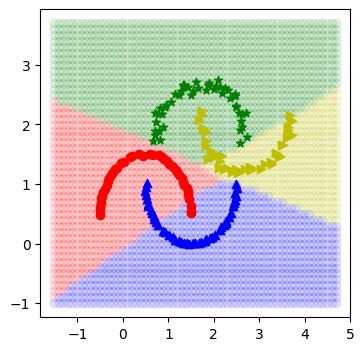

loss : 0.4387919553247554


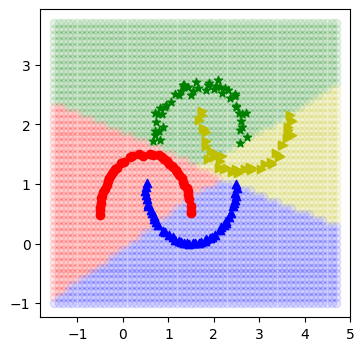

Epoch 61
-------------------------------
loss : 0.17929015110571397


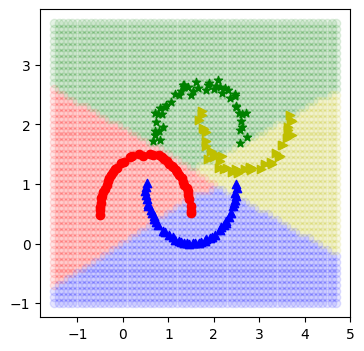

loss : 0.5682681718451728


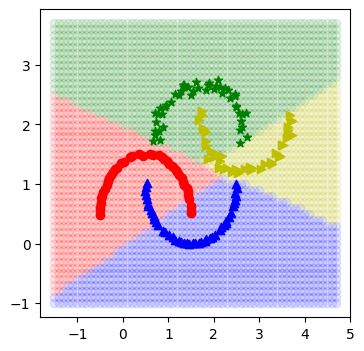

Epoch 71
-------------------------------
loss : 0.15587382664960905


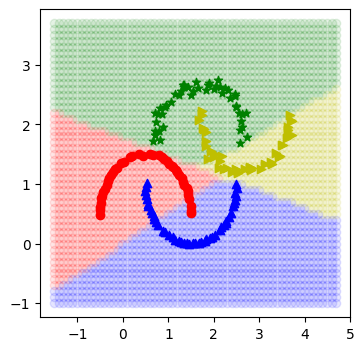

loss : 0.45830377264158934


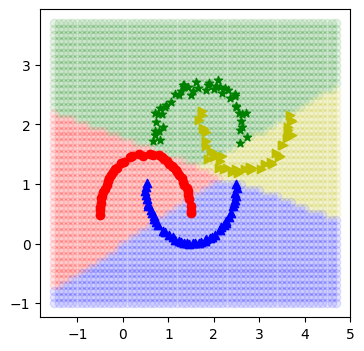

In [10]:
demo_neuron = SimpleDNN(2, 4)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 80
m = train_labels.shape[0]
for t in range(epochs):
    if t % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 10 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

#Exercise 2. Warm up exercise 2 with double moon dataset
## 1. Try to use a complex DNN to fix a multiple classes classfication problem


In [11]:
class ComplexDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 10),
            Sigmoid_Active_Function(),
            Linear(10, 10),
            Sigmoid_Active_Function(),
            Linear(10, 10),
            Sigmoid_Active_Function(),
            Linear(10, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

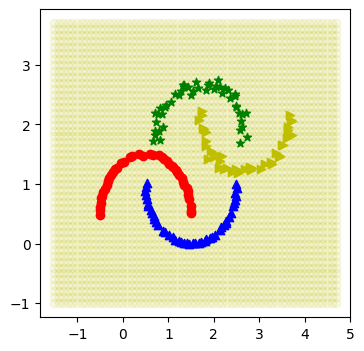

Epoch 1
-------------------------------
loss : 3.380170029887254


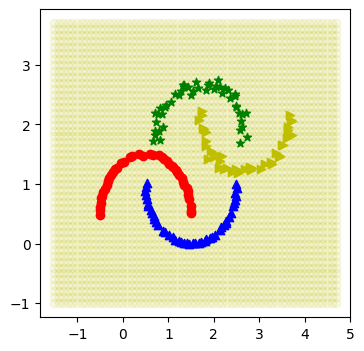

loss : 1.5994979436056416


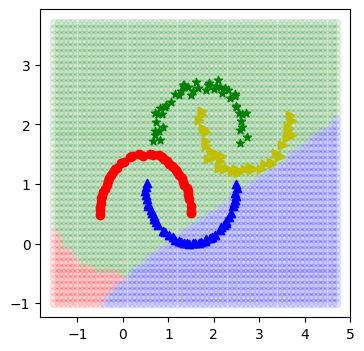

Epoch 51
-------------------------------
loss : 0.24503872416286243


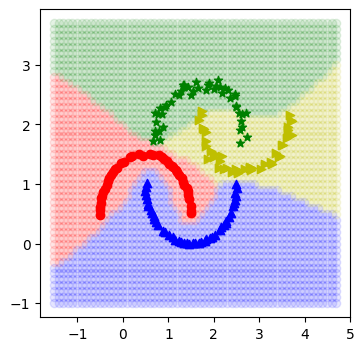

loss : 0.030934698823679038


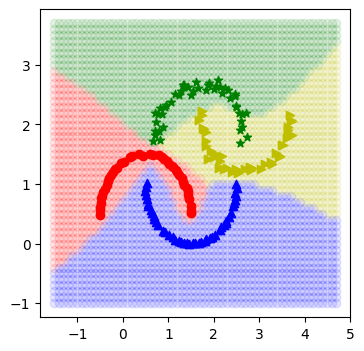

Epoch 101
-------------------------------
loss : 0.0017938339092147507


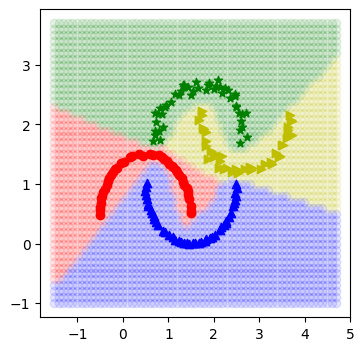

loss : 0.002264632980923783


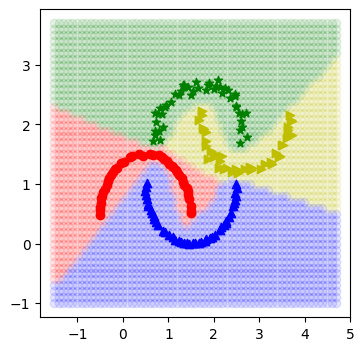

Epoch 151
-------------------------------
loss : 0.0005750518103510727


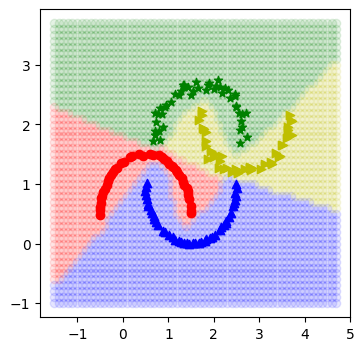

loss : 0.0009876200604169226


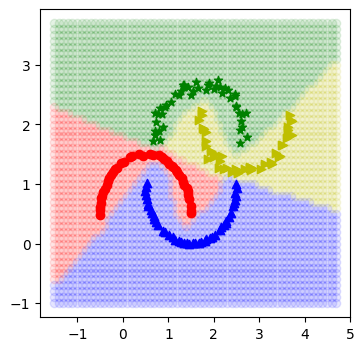

In [12]:
demo_neuron = ComplexDNN(2, 4)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 200
m = train_labels.shape[0]
for t in range(epochs):
    if t % 50 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 50 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

#Exercise 3: Warm up exercise 3
## 1. A more complicated multiple class classification problem


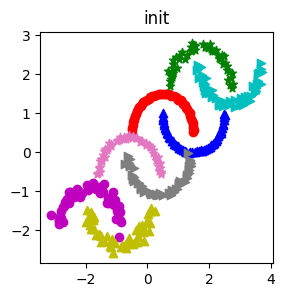

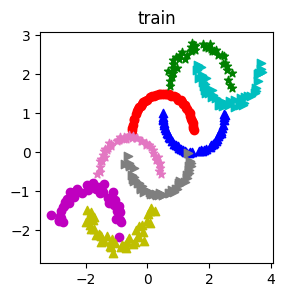

In [13]:
from sklearn.datasets import make_moons, make_circles
import matplotlib.colors as mcolors

time_of_iter = 4
size_of_sample = 100
size_of_features = 2
size_of_class = 2 * time_of_iter
#plot_colortable(mcolors.TABLEAU_COLORS, ncols=2, sort_colors=False)
markers = ['o', '^', '*', '>', 'o', '^', '*', '>', '<' ]
colors = ['r', 'b', 'g', 'c', 'm', 'y', mcolors.TABLEAU_COLORS['tab:pink'], mcolors.TABLEAU_COLORS['tab:gray'], mcolors.TABLEAU_COLORS['tab:olive']]
noises = [0.01, 0.06, 0.1, 0.04]
random_indexs = [0.5, 1.7, -1.9, -0.6]

feature_list = []
labels = np.zeros((size_of_sample * time_of_iter, size_of_class))

for i in range(time_of_iter):
    moon_features, moon_labels = make_moons(n_samples=size_of_sample, noise=noises[i])
    random_matrix = np.ones(moon_features.shape) * random_indexs[i]
    moon_features = moon_features + random_matrix

    for j in range(2):
        index = i * 2 + j
        matrix_where = i * size_of_sample + np.array(np.where(moon_labels == j))
        labels[matrix_where, index] = 1
    feature_list.append(moon_features)

features = np.concatenate(feature_list, axis=0)
train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')

In [14]:
class ComplexDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 20),
            Sigmoid_Active_Function(),
            Linear(20, 20),
            Sigmoid_Active_Function(),
            Linear(20, 20),
            Sigmoid_Active_Function(),
            Linear(20, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

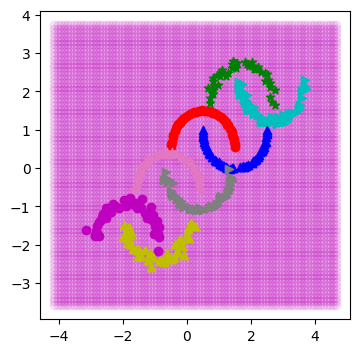

Epoch 1
-------------------------------
loss : 1.8956850455471455


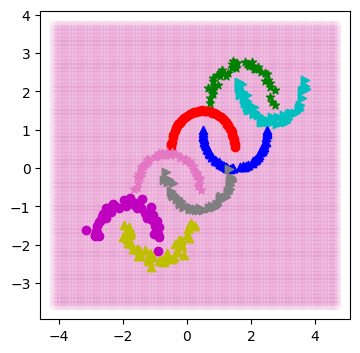

loss : 0.5734958796740947


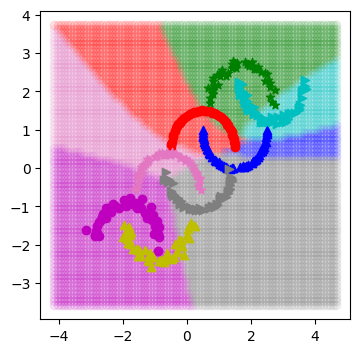

Epoch 101
-------------------------------
loss : 0.0017428522727845701


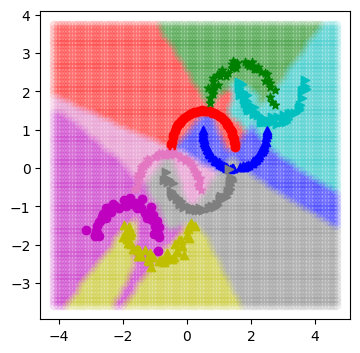

loss : 6.871952357077277e-06


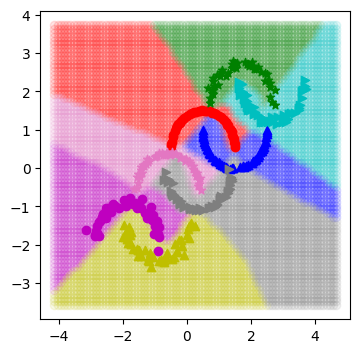

Epoch 201
-------------------------------
loss : 0.0005939201917167323


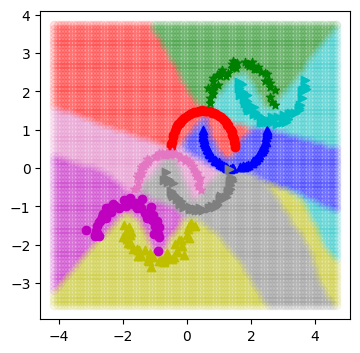

loss : 7.555852967741279e-06


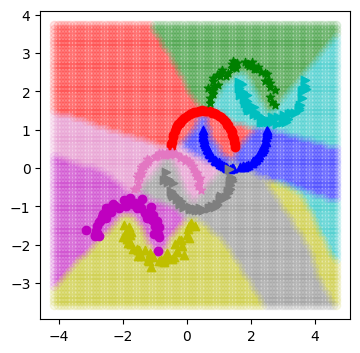

Epoch 301
-------------------------------
loss : 0.0006149625971177429


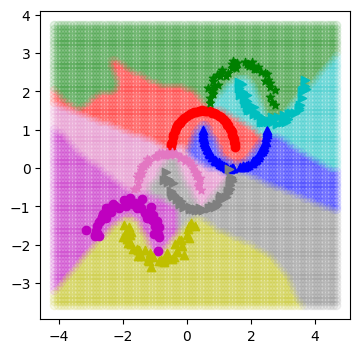

loss : 6.756081277947112e-06


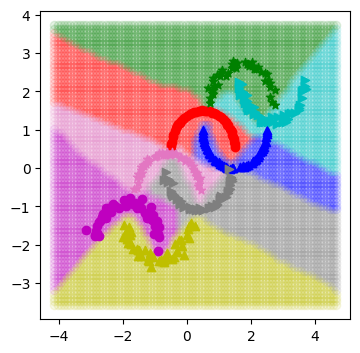

In [15]:
demo_neuron = ComplexDNN(2, 8)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 400
m = train_labels.shape[0]
for t in range(epochs):
    if t % 100 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 100 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

#Exercise 4: A classical experiment -- MNIST
1. Use your implement of DNN to get a baseline
2. Try to implement your simple CNN model and get the correct bp
3. Use Pytorh CNN model to compare with your own CNN in the effect and speed


In [16]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [17]:
tt = transforms.Compose([transforms.ToTensor()])

train_data = MNIST(root='./data', train=True, transform=tt, download=True)
#test_data = MNIST(root='./data', train=False, transform=tt)

100%|██████████| 9912422/9912422 [00:00<00:00, 88174737.27it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 86340480.27it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24803877.00it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15500837.08it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([60000, 28, 28])
torch.Size([60000])


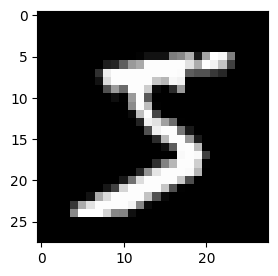

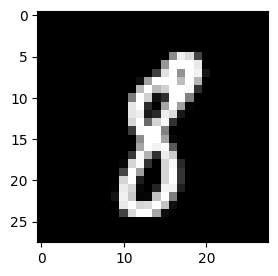

In [18]:
np_train_features = train_data.data.numpy()
np_train_labels = train_data.targets.numpy()

print(train_data.data.shape)
print(train_data.targets.shape)
#print(test_data.data.shape)
#print(test_data.targets.shape)

#print(train_data.data[0])
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(3, 3))
plt.imshow(np_train_features[0], cmap='gray')
plt.show()
figure = plt.figure(figsize=(3, 3))
plt.imshow(np_train_features[300], cmap='gray')
plt.show()

In [19]:
import numpy as np
train_features = np.resize(np_train_features, (np_train_features.shape[0], 28 * 28))
train_labels = np.zeros((np_train_labels.shape[0], 10))
for i in range(10):
    train_labels[np.where(np_train_labels == i), i] = 1

In [20]:
print(train_features.shape)
print(train_labels.shape)
print(train_labels[0])

(60000, 784)
(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [42]:
class MnistDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 100),
            Sigmoid_Active_Function(),
            Linear(100, 100),
            Sigmoid_Active_Function(),
            Linear(100, 100),
            Sigmoid_Active_Function(),
            Linear(100, 100),
            Sigmoid_Active_Function(),
            Linear(100, 50),
            Sigmoid_Active_Function(),
            Linear(50, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

In [43]:
def shuffle_dataset(n, batch_size):
    idices= np.array(range(n))
    np.random.shuffle(idices)
    batch_sample_size = int((n - n % batch_size) / batch_size)
    m = int(batch_size * batch_sample_size)
    a = idices[0:m].reshape((batch_size, batch_sample_size))
    b = idices[m:].reshape((1, n % batch_size))
    return a

shuffle_dataset(100, 4)

array([[ 4, 29, 76, 20, 11, 46, 32,  3, 65,  9,  0, 25, 41, 95, 55,  6,
        39, 61, 30, 45, 90, 40, 72, 16, 78],
       [81, 27, 93, 51, 52, 59, 66,  5, 74, 26, 92, 89, 73, 79, 57, 87,
         2, 53, 42, 56, 33, 12, 75, 24, 62],
       [ 7, 91, 58, 69, 19, 86, 35, 23, 71, 18, 82, 98, 17, 21, 13, 37,
        88, 36, 94, 60, 50, 96, 67, 34, 14],
       [85, 44, 77, 84, 48, 10, 63,  1, 22, 43, 83, 31, 80, 68, 97, 70,
        47, 54, 28, 15, 64, 99, 38, 49,  8]])

In [47]:
demo_neuron = MnistDNN(28*28, 10)
loss = Cross_Entropy_Loss()

epochs = 1000
m = train_labels.shape[0]
for t in range(epochs):
    if t % 100 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    batch_matrix = shuffle_dataset(m, 6000)
    batch_size = int(m / 6000)
    l = 0.
    for batch_id in range(batch_size):
        batch_index = batch_matrix[batch_id, :]
        X = train_features[batch_index, :]
        Y = train_labels[batch_index, :]

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.1)

        #if iter_id % (m-1) == 0 and t % 100 == 0:
        #print('batch:', batch_id, ' t:', t+1, ' loss :', l)
    print('t:', t+1, ' loss :', l)

Epoch 1
-------------------------------
t: 1  loss : 45.10273872186625


<ipython-input-4-3f2d46d86fdd>:2: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))


t: 2  loss : 39.7070982441998
t: 3  loss : 37.35847658644124
t: 4  loss : 37.78167620812793
t: 5  loss : 34.37045824944537
t: 6  loss : 34.71044611457339
t: 7  loss : 26.045585692172317
t: 8  loss : 62.0773308271298
t: 9  loss : 32.96250072886912
t: 10  loss : 24.940394369876
t: 11  loss : 26.89875755057286
t: 12  loss : 23.308547169955887
t: 13  loss : 24.861594304509342
t: 14  loss : 24.439747003010872
t: 15  loss : 29.101928764681766
t: 16  loss : 21.665120221103866
t: 17  loss : 25.93227277925608
t: 18  loss : 26.096726525959305
t: 19  loss : 23.331504595655282
t: 20  loss : 24.744138538999785
t: 21  loss : 26.952705141396734
t: 22  loss : 21.678741865590347
t: 23  loss : 24.556425424427857
t: 24  loss : 23.195456611121926
t: 25  loss : 21.68217882819253
t: 26  loss : 25.826557140615282
t: 27  loss : 27.7959589298932
t: 28  loss : 23.26667444356289
t: 29  loss : 26.935377208329086
t: 30  loss : 23.039063032956534
t: 31  loss : 29.5909186424647
t: 32  loss : 18.633208122933176
t: 33